## Training a model and making predictions

In order to train and optimize VAESIMCA model, first we need to define encoder and decoder classes for the Variational Autoencoder. The classes must inherit `torch.nn.Module` class and the constructor must have two parameters: `img_size` - which is a tuple with image width, height and number of channels, and `latent_dim` - dimension of the latent space.

Here is an example of simple encoder and decoder which are also used in the examples from the paper:

In [1]:
# load all packages needed to run the code in this notebook
import matplotlib.pyplot as plt

from torchvision import transforms
from torch import nn, sigmoid
from torch.nn import functional as F
from vaesimca import VAESIMCA

In [2]:

# define the encoder class
class Encoder(nn.Module):
    def __init__(self, img_size, latent_dim):
        super(Encoder, self).__init__()
        img_width, img_height, nchannels = img_size
        self.conv1 = nn.Conv2d(nchannels, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(256 * (img_width // 16) * (img_height // 16), latent_dim)
        self.fc_logvar = nn.Linear(256 * (img_width // 16) * (img_height // 16), latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1) # flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# define the decoder class
class Decoder(nn.Module):
    def __init__(self, img_size, latent_dim):
        super(Decoder, self).__init__()
        img_width, img_height, nchannels = img_size
        self.img_width = img_width
        self.img_height = img_height
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 256 * (img_width // 16) * (img_height // 16))
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, nchannels, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 256, (self.img_width // 16), (self.img_height // 16))
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        z = sigmoid(self.deconv4(z))
        return z


The next step is to define a sequence of transformations for the images. This sequence should at least include the resizing (to ensure that all images have the same size) and normalization to [0, 1] range which can be done by simply applying `toTensor()` transformation. Here is an example:

In [3]:
img_size = (128, 128, 1)

# define transformations
transform = transforms.Compose([
    transforms.Resize([img_size[0], img_size[1]]),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In the code above we also set `img_size` value for the simulated images.

After that you need to define path to the training set. The directory should contain an image folder whose name will be the same as a target class name you want to train the model for. If the directory also contains other folders, they will be ignored.

In [4]:
train_path = "images_simulated/train"
classname = "target"

Now we can initialize and train the model (here in all examples the number of epochs is relatively small to make computation faster):

In [5]:
# model and training parameters
latent_dim = 6
nepochs = 30
lr = 0.00001

# initialize the model object
m = VAESIMCA(encoder_class=Encoder, decoder_class=Decoder, classname = classname,
                img_size=img_size, latent_dim=latent_dim, transform=transform)

# train the model
m.train(data_path=train_path, nepochs=nepochs, lr = lr)

Training VAE model (nimg: 1000 dim: 6, epochs: 30)
Epoch 1/30, Loss: 10390.879055
Epoch 11/30, Loss: 5723.208418
Epoch 21/30, Loss: 5647.661273
Epoch 30/30, Loss: 5631.420141


The `train()` method has additional argument, `verbose`, which is by default set `True`. In this case the training process will provide some information every 10 epochs (the training lost). To suppress this simply set the parameter to `False`:

In [6]:
# train the model without output
m.train(data_path=train_path, nepochs=nepochs, lr = lr, verbose = False)

Once the model is trained one can start using it to make predictions for other images. Here is an example how to make predictions for the training set and for the test set which contains three classes (`target`, `alt1`, `alt2`):

In [7]:

# make predictions and show summary for training set
rc = m.predict(data_path=train_path)
rc.summary()


class      n   in in (%)  out out (%)
-------------------------------------
target  1000  920   92.0   80     8.0


In [8]:
# make predictions and show summary for test set located in a separate folder
test_path = "images_simulated/test"
rt = m.predict(data_path=test_path)
rt.summary()


class      n   in in (%)  out out (%)
-------------------------------------
alt1     100   74   74.0   26    26.0
alt2     100    8    8.0   92    92.0
target   100   86   86.0   14    14.0


The `predict()` method returns the `VAESIMCARes` object which contains all outcomes: distances, scores, etc. It has several methods which let you assess the performance of the model. For each class found in the directory `data_path`, it simply computes the number of objects which were accepted by the model as target class members (`in`) or rejected as strangers (`out`).

Method `summary()` prints this information a readable way, but it can also be obtained as a dictionary by using method `stat()`:

In [9]:
# get results of classification for each class as a dictionary
s = rt.stat()
print(s)

{'alt1': [100, 74, 26], 'alt2': [100, 8, 92], 'target': [100, 86, 14]}


By default the prediction is made for significance level of 0.05, which means that 5% of target class members will be rejected (in theory), so the expected sensitivity of the model is 0.95. This can be changed by providing additional parameter to the predict method:

In [10]:
# make predictions using decision boundary computed for SL = 0.01
rt2 = m.predict(data_path=test_path, alpha = 0.01)
rt2.summary()


class      n   in in (%)  out out (%)
-------------------------------------
alt1     100   92   92.0    8     8.0
alt2     100   18   18.0   82    82.0
target   100   96   96.0    4     4.0


The results can also be visualized using two plots. The first is the *Distance plot*, which shows the distance values in form of bar plots:

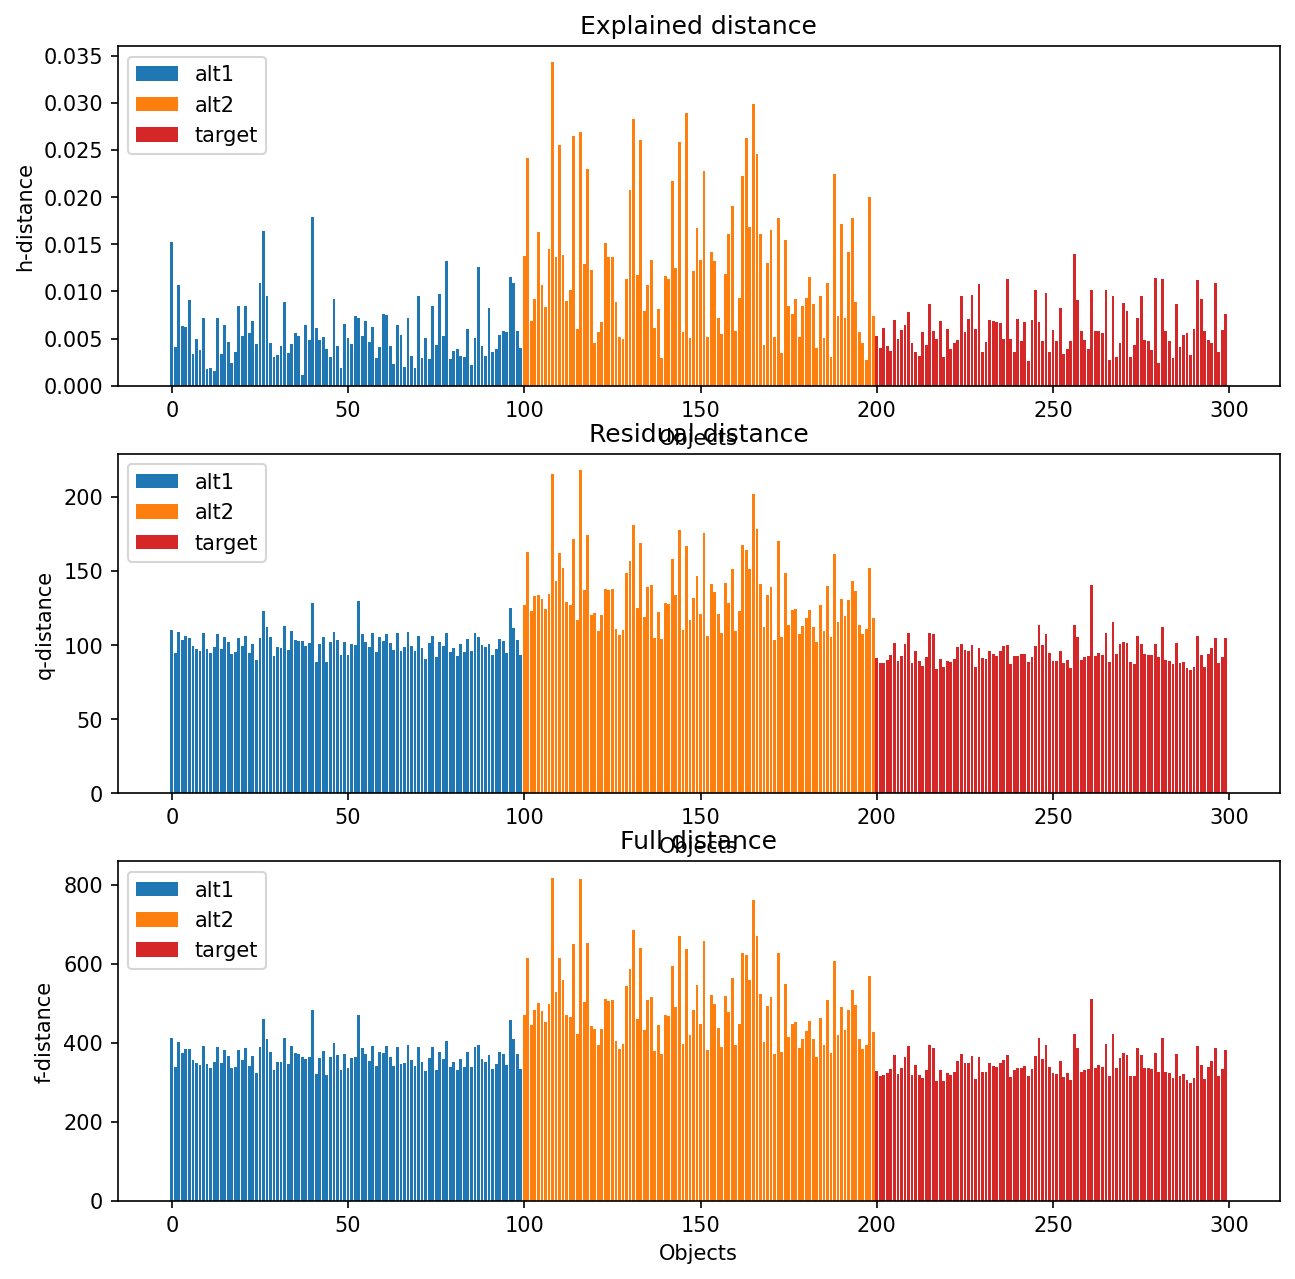

In [11]:

plt.figure(figsize=(10, 10), dpi = 150)

plt.subplot(3, 1, 1)
rt.plotDistance(plt, distance="h")

plt.subplot(3, 1, 2)
rt.plotDistance(plt, distance="q")

plt.subplot(3, 1, 3)
rt.plotDistance(plt, distance="f")

For each distance you can show the statistical boundaries (for detection of extreme objects and outliers) as well as the object labels:

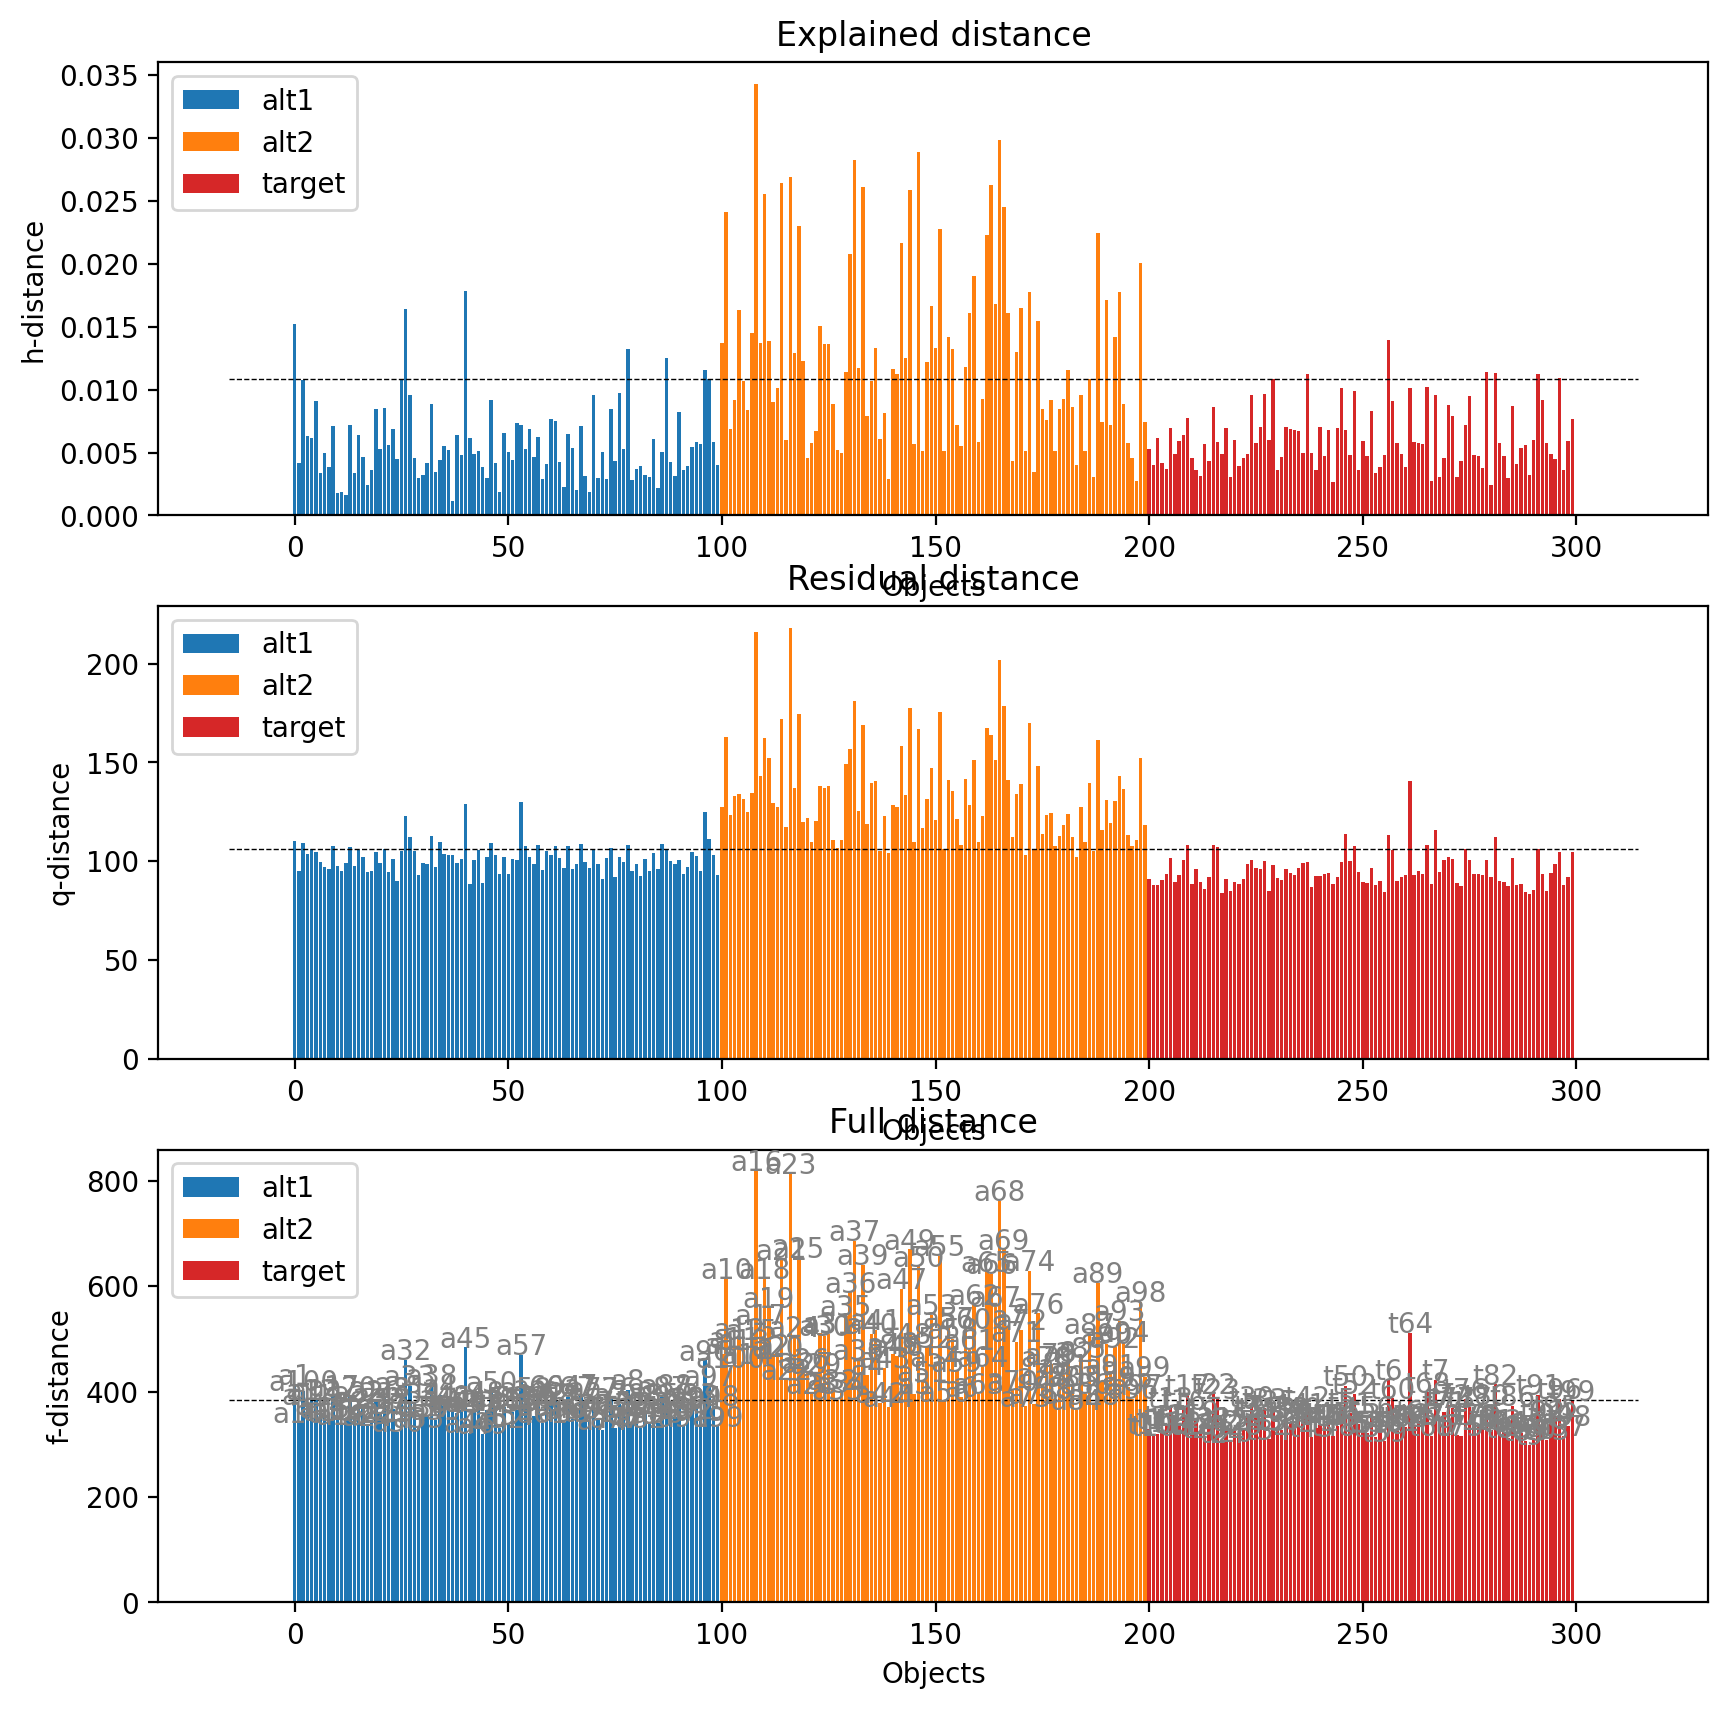

In [12]:
plt.figure(figsize=(10, 10), dpi = 200)

plt.subplot(3, 1, 1)
rt.plotDistance(plt, distance="h", show_boundaries=True)

plt.subplot(3, 1, 2)
rt.plotDistance(plt, distance="q", show_boundaries=True)

plt.subplot(3, 1, 3)
rt.plotDistance(plt, distance="f", show_boundaries=True, show_labels=True)

The second is the *Acceptance plot*, which shows the scaled explained and residual distances in form of a scatter plot together with the decision boundary. It is also possible to show the object labels and use log-transformed distance values, which are in general improve the plot readability:

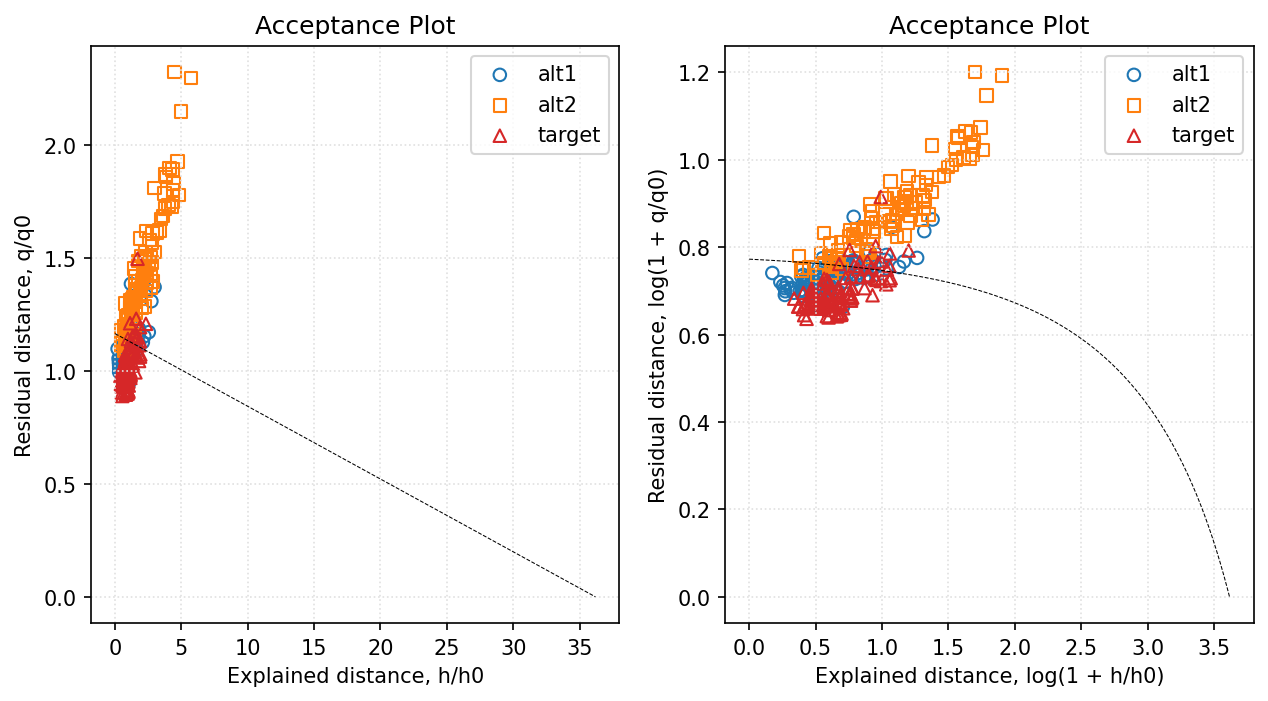

In [13]:
plt.figure(figsize=(10, 5), dpi = 150)

plt.subplot(1, 2, 1)
rt.plotAcceptance(plt)
plt.subplot(1, 2, 2)
rt.plotAcceptance(plt, dolog = True)

In both plots, user can modify colors used to show outcomes of each class as well as the markers in case of the acceptance plot. Check the documentation of the methods for details.

Finally one can get full set of results including object labels, distances, decision etc. as a data frame:

In [14]:
res_df = rt.as_df()
print(res_df)
print(m.fParams)
print(res_df["sample"])

    sample   class  decision         h           q           f
0       a1    alt1     False  0.015247  110.001916  413.137064
1      a10    alt1      True  0.004147   94.822617  340.217687
2     a100    alt1     False  0.010731  109.063354  401.854388
3      a11    alt1      True  0.006329  103.440572  374.330606
4      a12    alt1      True  0.006190  106.137817  383.553324
..     ...     ...       ...       ...         ...         ...
295    t95  target      True  0.004495   98.389169  353.353200
296    t96  target     False  0.010925  104.601509  386.533618
297    t97  target      True  0.003621   88.223313  316.119143
298    t98  target      True  0.005920   92.208142  334.173979
299    t99  target      True  0.007632  104.831451  381.517945

[300 rows x 6 columns]
(340.0912328185411, 340.0912328185411)
0        a1
1       a10
2      a100
3       a11
4       a12
       ... 
295     t95
296     t96
297     t97
298     t98
299     t99
Name: sample, Length: 300, dtype: object


Here the `decision` column is logical, `True` if object was accepted as a member of the target class by the model and `False` if it was rejected. Same about the `outlier` object. The sample labels are image file names without the extension.

Finally, you can also plot the reconstruction error for an image with given label from a given class (you need to specify both to avoid possible ambiguity as images in different folders may have the same names):

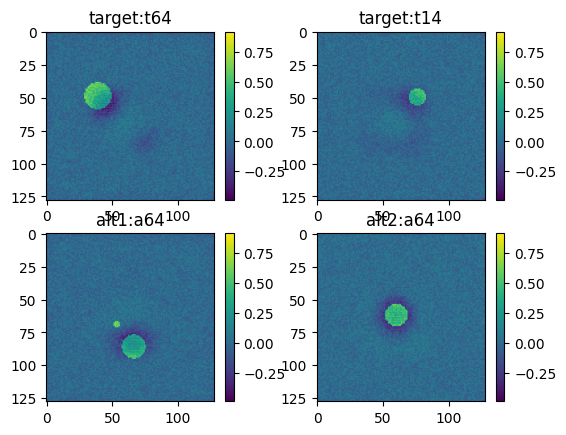

In [20]:
plt.subplot(2, 2, 1)
rt.plotError(plt, classname = "target", object_label="t64")
plt.subplot(2, 2, 2)
rt.plotError(plt, classname = "target", object_label="t14")
plt.subplot(2, 2, 3)
rt.plotError(plt, classname = "alt1", object_label="a64")
plt.subplot(2, 2, 4)
rt.plotError(plt, classname = "alt2", object_label="a64")


## Optimization of the model parameters

The `VAESIMCA` class has a static method `gridsearch()` which simplifies optimization of two main parameters: the dimension of the latent space and the learning rate. It requires both training and test set for the optimization as well as other components and settings necessary to train the `VAESIMCA` model: encoder and decoder classes, transformation function, number of epochs, etc.

Here is an example, where it trains the models for 6 different combination of learning rate and latent space dimension and returns results for training and test sets in form dictionaries with 2D arrays. Every array contains percent of objects in each class that was accepted by the corresponding model.

In [16]:
# gridsearch example — !!! note it will take time to run this code !!!

train_path = "images_simulated/train"
test_path = "images_simulated/test"
classname = "target"
img_size = (128, 128, 1)

nepochs = 30
lr_seq = [10E-5, 1E-4]
ld_seq = [4, 8, 16]

lr_seq, ld_seq, train_res, test_res = VAESIMCA.gridsearch(
    train_path=train_path, test_path=test_path, encoder_class=Encoder, lr_seq=lr_seq, ld_seq=ld_seq,
    nepochs=nepochs, decoder_class=Decoder, classname = classname, img_size=img_size, transform=transform
)

lr: 0.0001000	ld:    4 >> target: 0.943 - alt1: 0.030 - alt2: 0.000 - target: 0.890
lr: 0.0001000	ld:    8 >> target: 0.925 - alt1: 0.010 - alt2: 0.000 - target: 0.810
lr: 0.0001000	ld:   16 >> target: 0.930 - alt1: 0.040 - alt2: 0.000 - target: 0.890
lr: 0.0001000	ld:    4 >> target: 0.928 - alt1: 0.010 - alt2: 0.000 - target: 0.860
lr: 0.0001000	ld:    8 >> target: 0.927 - alt1: 0.010 - alt2: 0.000 - target: 0.910
lr: 0.0001000	ld:   16 >> target: 0.937 - alt1: 0.090 - alt2: 0.000 - target: 0.890


Here we reuse the encoder/decoder classes and transformation function from the examples above. By default grid search shows results for each step, this can be suppressed by providing additional argument `verbose = False`

The results can be used to compute matrices with statistics. Thus in this case we know, that images in folder `target` are indeed members of the target class, while images from the folders `alt1` and `alt2` are members of alternative classes. This allows us to compute sensitivity, specificity and efficiency for the test set results (and sensitivity for the training set) for each combination of the learning rate and latent dimension:

In [17]:
import numpy as np

sensc = train_res["target"]      # sensitivity for the training set
senst = test_res["target"]       # sensitivity for the test set
spect = 1 - test_res["alt1"]     # specificity for the test set
efft = np.sqrt(senst * spect )   # efficiency for the test set

print(efft)

[[0.92913939 0.89548869 0.9243376 ]
 [0.92271339 0.94915752 0.89994444]]



Note that in this case we do not use images from class `alt2` for calculations, because I know in advance (see paper for details), that they are more dissimilar to the target class than the images from class `alt1`.

These statistics can be visualized in form of heatmaps, for example using another static method, `plotperformance()`:

Text(0.5, 1.0, 'Efficiency (test)')

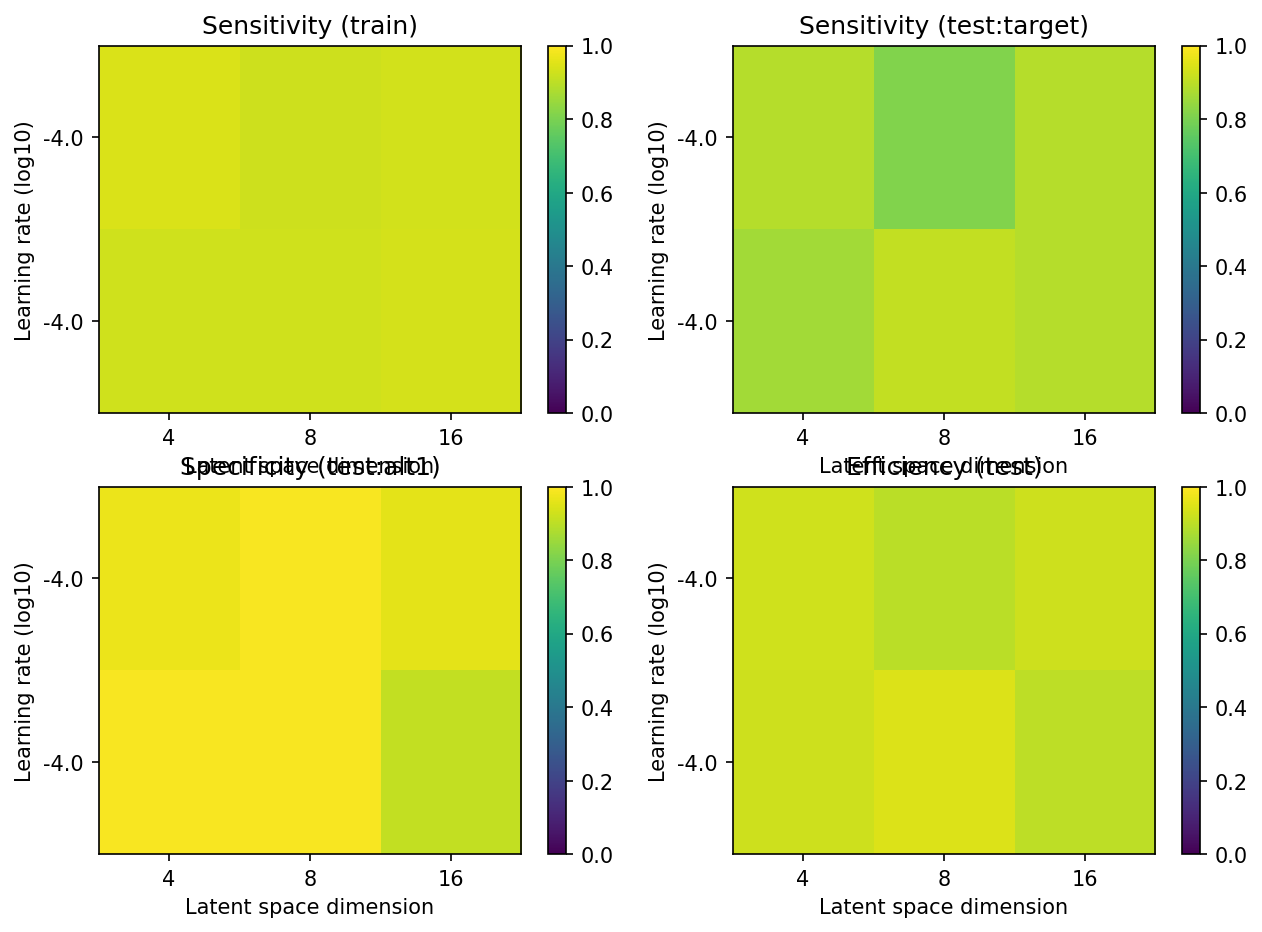

In [18]:
plt.figure(figsize=(10, 7), dpi = 150)

plt.subplot(2, 2, 1)
VAESIMCA.plot_performance(plt, s = sensc, lr_seq=lr_seq, ld_seq=ld_seq)
plt.title("Sensitivity (train)")

plt.subplot(2, 2, 2)
VAESIMCA.plot_performance(plt, s = senst, lr_seq=lr_seq, ld_seq=ld_seq)
plt.title("Sensitivity (test:target)")

plt.subplot(2, 2, 3)
VAESIMCA.plot_performance(plt, s = spect, lr_seq=lr_seq, ld_seq=ld_seq)
plt.title("Specificity (test:alt1)")

plt.subplot(2, 2, 4)
VAESIMCA.plot_performance(plt, s = efft, lr_seq=lr_seq, ld_seq=ld_seq)
plt.title("Efficiency (test)")

If necessary one can also provide a threshold value, in the example below the right plot shows sensitivity values binarized using the threshold of 0.9.

Text(0.5, 1.0, 'Sensitivity (test:target) - binarized')

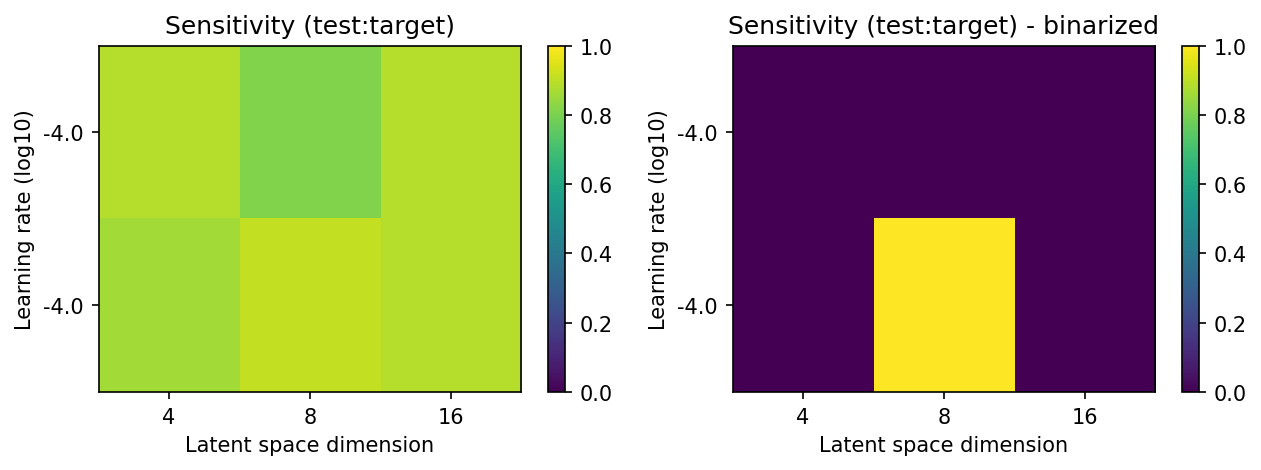

In [19]:

plt.figure(figsize=(10, 3), dpi = 150)

plt.subplot(1, 2, 1)
VAESIMCA.plot_performance(plt, s = senst, lr_seq=lr_seq, ld_seq=ld_seq)
plt.title("Sensitivity (test:target)")

plt.subplot(1, 2, 2)
VAESIMCA.plot_performance(plt, s = senst, lr_seq=lr_seq, ld_seq=ld_seq, threshold=0.9)
plt.title("Sensitivity (test:target) - binarized")
